## Data preparation
This file concatenates data from the different models. We create the following files:
- CMIP5_time_series.nc
- CMIP5_time_series_smoothed.nc
- CMIP6_time_series.nc
- CMIP6_time_series_smoothed.nc
- CMIP5_spatial_zos.nc
- CMIP6_spatial_zos.nc
- CMIP5_spatial_MLD.nc
- CMIP5_spatial_MLD_mlotst.nc
- CMIP5_spatial_MLD_Heuzé.nc
- CMIP6_spatial_MLD.nc
- CMIP6_spatial_MLD_mlotst.nc
- CMIP6_spatial_MLD_Heuzé.nc

In [6]:
# Load packages
import glob

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import xesmf as xe

import statsmodels.api as sm            # to build a LOWESS model
from scipy.interpolate import interp1d  # for interpolation of new data points
lowess = sm.nonparametric.lowess

import dask.config as dc
dc.set(**{'array.slicing.split_large_chunks': True});

In [7]:
# Select directories
original_data_dir = 'Raw_Data/'
write_data_to_dir = 'Data/'

standard_reference_period = [1900, 1950]

## Spatial zos
In this section, we create:
- CMIP5_spatial_zos.nc
- CMIP6_spatial_zos.nc

In [8]:
def read_zos_ds(data_dir, mip, sce):
    """
    Read both historical and scenario datasets, select the intersecting 
    models and concatenate the two datasets
    """
    
    hist_ds = xr.open_mfdataset(
        f'{data_dir}/{mip}_zos_historical/{mip}_zos_historical_*.nc')
    sce_ds = xr.open_mfdataset(
        f'{data_dir}/{mip}_zos_{sce}/{mip}_zos_{sce}_*.nc')

    model_intersection = list(set(hist_ds.model.values) & 
                              set(sce_ds.model.values))
    model_intersection.sort()
   
    tot_ds = xr.concat([hist_ds, sce_ds], 'time').sel(model = model_intersection, time = slice(1900, 2101))

    return tot_ds


def concat_zos_data(data_dir, mip, ref_start, ref_end):
    """
    Concatenate different scenarios and set reference period.
    """
    
    scenarios_dic = {'cmip5': [ 'rcp26',  'rcp45',  'rcp85'],
                     'cmip6': ['ssp126', 'ssp245', 'ssp585']}
    
    zos_mip = [[],[],[]]
    
    for i, sce in enumerate(scenarios_dic[mip]):

        # Read data for specific scenario
        zos = read_zos_ds(data_dir, mip, sce)

        # Set right reference period and select North Eastern region of the North Atlantic
        zos = zos - zos.sel(time=slice(ref_start, ref_end)).mean(dim='time')
        zos = zos.sel(lat=slice(15,82), lon=slice(-45,60))
        
        # Rename variable and add scenario to dimensions
        zos = zos.rename({'CorrectedReggrided_zos':'spatial_zos'})
        zos = zos.assign_coords({'scenario': sce})

        # Fill in overarching list
        zos_mip[i] = zos 
    
    # Concatenate different scenarios
    zos_mip = xr.concat(zos_mip, dim='scenario')

    return zos_mip

In [9]:
CMIP5_spatial_zos = concat_zos_data(original_data_dir, 'cmip5', 1900, 1950)
CMIP6_spatial_zos = concat_zos_data(original_data_dir, 'cmip6', 1900, 1950)

CMIP5_spatial_zos.to_netcdf(write_data_to_dir+'CMIP5_spatial_zos.nc')
CMIP6_spatial_zos.to_netcdf(write_data_to_dir+'CMIP6_spatial_zos.nc')

In [10]:
CMIP5_spatial_zos.close()
CMIP6_spatial_zos.close()

## Time series
In this section, we create:
- CMIP5_time_series.nc
- CMIP5_time_series_smoothed.nc
- CMIP6_time_series.nc
- CMIP6_time_series_smoothed.nc

In [11]:
# Functions to read GSAT
def select_tglob_cmip6_files(data_dir, sce, verbose=False):
    '''The file name of cmip6 tglob files from the climate explorer contains 
    some information about the variant as well. Only one needs to be chosen 
    and the name of the model needs to be cleaned.'''
    
    path = f'{data_dir}global_tas_mon_*_{sce}_000.dat'
    files  = glob.glob(path)

    model_names = []
    for f in files:
        file_name_no_path = f.split('/')[-1]
        model_name = file_name_no_path.split('_')[3]
        model_names.append(model_name)

    model_names.sort()

    clean_model_names = []
    lp_list = []
    for m in model_names:
        lp = m.split('-')[-1]
        lp_list.append(lp)
        if lp in ['f2', 'p2', 'p1', 'p3', 'f3']:
            clean_model_names.append(m[:-3])
        else:
            clean_model_names.append(m)

    df = pd.DataFrame({'model_names': model_names,
                       'clean_model_names': clean_model_names,
                       'fp': lp_list})

    for m in df['clean_model_names']:
        if (list(df['clean_model_names']).count(m) > 1):
            fp_choice = df[df.clean_model_names==m]['fp']
            ind = df[(df.fp!=fp_choice.iloc[0]) & (df.clean_model_names==m)].index
            
            if verbose:
                print(f'Multiple variants of {m}')
                print('Available variants')
                print(fp_choice)
                print(f'Choosing {fp_choice.iloc[0]}')
                
            df.drop(ind, inplace=True)

    file_list = []
    for m in df.model_names:
        file_list.append(f'{data_dir}global_tas_mon_{m}_{sce}_000.dat')
    
    df['file_names'] = file_list
    
    return df

def tglob_cmip(data_dir, mip, sce, start_date, ye, LowPass=False):
    '''Read the text files of monthly temperature for each CMIP5 model and store
    yearly averged values in an xarray DataArray.
    Output data is in degree Kelvin'''
    
    #nb_y = ye-start_date+1
    
    if mip == 'CMIP5':
        temp_data_dir = f'{data_dir}Tglobal_CMIP5/'
        path = f'{temp_data_dir}global_tas_Amon_*_{sce}_r1i1p1.dat'
        files = glob.glob(path)
        print(files[1][39:-17])
        model_names = [f[39:-17] for f in files]
        df = pd.DataFrame({'clean_model_names': model_names, 'file_names': files})
        
    elif mip =='CMIP6':
        temp_data_dir = f'{data_dir}Tglobal_CMIP6/'
        df = select_tglob_cmip6_files(temp_data_dir, sce)
        
    else:
        print(f'ERROR: Value of TEMP: {mip} not recognized')

    
    col_names = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
                 'Sep', 'Oct', 'Nov', 'Dec']

    for i in range(len(df)):
        TEMP = pd.read_csv(df.file_names.iloc[i], 
                           comment='#', 
                           delim_whitespace=True,
                           names=col_names)
        TEMP = TEMP.set_index('Year')
        TGLOBi = xr.DataArray(TEMP.mean(axis=1))
        mod = df.clean_model_names.iloc[i]
        TGLOBi = TGLOBi.expand_dims({'model':[mod]})

        if i==0:
            TGLOB = TGLOBi
        else:
            TGLOB = xr.concat([TGLOB, TGLOBi], dim='model')

    TGLOB = TGLOB.rename({'Year':'time'})
    TGLOB = TGLOB.sel(time=slice(start_date,ye))

    if LowPass:
        new_time = xr.DataArray( np.arange(start_date,ye+1), dims='time', 
                coords=[np.arange(start_date,ye+1)], name='time' )
        fit_coeff = TGLOB.polyfit('time', 2)
        TGLOB = xr.polyval(coord=new_time, coeffs=fit_coeff.polyfit_coefficients) 

    TGLOB.name = 'GSAT'
    
    return TGLOB


In [12]:
# Functions to read GMTSL
def read_zostoga_ds(data_dir, mip, sce):
    '''Read both historical and scenario datasets, select the intersecting 
    models and concatenate the two datasets'''
    
    hist_ds = xr.open_mfdataset(
        f'{data_dir}/{mip}_zostoga/{mip}_zostoga_historical_*.nc')*100
    sce_ds = xr.open_mfdataset(
        f'{data_dir}/{mip}_zostoga/{mip}_zostoga_{sce}_*.nc')*100

    model_intersection = list(set(hist_ds.model.values) & 
                              set(sce_ds.model.values))
    model_intersection.sort()
    tot_ds = xr.concat([hist_ds,sce_ds],'time').sel(model=model_intersection)
    
    return tot_ds


In [13]:
# Functions to read AMOC
""" 
Note that we have two groups of models:
    - AMOC computed using stream function           (read_amoc_ds_using_streamfunction)
    - AMOC computed using meridional velocities     (read_amoc_ds_using_velocities)

"""

def read_amoc_ds_using_streamfunction(data_dir, mip, sce):
    '''
    Read both historical and scenario datasets, select the intersecting 
    models and concatenate the two datasets. 
    '''
    
    tot_ds = []
    
    # From mstmz to sverdrup 
    DF = 1026*10**6 
    
    if mip == 'cmip5':
        variable_name = ['msftmyz']
    elif mip == 'cmip6':
        variable_name = ['msftmz','msftyz']
    else:
        print('mip is not recognized')
        
    for var in variable_name:
        for reg in ['26N', '35N']:
            hist_ds = xr.open_mfdataset(
                f'{data_dir}/{mip}_amoc/{mip}_{var}_{reg}_historical_*.nc')
            sce_ds = xr.open_mfdataset(
                f'{data_dir}/{mip}_amoc/{mip}_{var}_{reg}_{sce}_*.nc')
            
            if sce == 'rcp45':
                sce_ds = sce_ds.isel(model=[0,1,2,3,4,5,7,8,9,10,11])
            
            model_intersection = list(set(hist_ds.model.values) & set(sce_ds.model.values))
            model_intersection.sort()
            
            if sce == 'rcp45':
                model_intersection.remove('CNRM-CM5')
                CNRM5 = xr.concat([hist_ds,sce_ds],'time').sel(model='CNRM-CM5')*10**6
                Mods_no = xr.concat([hist_ds,sce_ds],'time').sel(model=model_intersection)
                tot_ds.append(xr.concat([Mods_no,CNRM5],'model')) #.sel(model=model_intersection))
            
            else:
                tot_ds.append(xr.concat([hist_ds,sce_ds],'time').sel(model=model_intersection))
            
    if mip == 'cmip5':
        my26N, my35N = tot_ds
        
        
        xr_my = xr.Dataset(
            data_vars=dict(
                AMOC26 = (["model", "time"], my26N.msftmyz.values/DF),
                AMOC35 = (["model", "time"], my35N.msftmyz.values/DF),
            ),
            coords=dict(
                model= my26N.model.values,
                time = my26N.time.values,
            ),
            attrs=dict(description="Dataset with AMOC, zos data."),
        )
        AMOC = xr_my
        
    elif mip == 'cmip6':
        m26N, m35N, y26N, y35N = tot_ds
    
        modsm = m26N.model.values
        modsy = y26N.model.values
    
        overlap = np.sort(list(set(modsm)&set(modsy)))
    
        new_modsy = np.array([ele for ele in modsy if ele not in overlap])
    
        y26N = y26N.sel(model=new_modsy)
        y35N = y35N.sel(model=new_modsy)
    
        xr_m = xr.Dataset(
            data_vars=dict(
                AMOC26 = (["model", "time"], m26N.msftmz.values/DF),
                AMOC35 = (["model", "time"], m35N.msftmz.values/DF),
            ),
            coords=dict(
                model= modsm,
                time = m26N.time.values,
            ),
            attrs=dict(description="Dataset with AMOC, zos data."),
        )
    
        xr_y = xr.Dataset(
            data_vars=dict(
                AMOC26 = (["model", "time"], y26N.msftyz.values/DF),
                AMOC35 = (["model", "time"], y35N.msftyz.values/DF),
            ),
            coords=dict(
                model= new_modsy,
                time = y26N.time.values,
            ),
            attrs=dict(description="Dataset with AMOC, zos data."),
        )
    
        AMOC = xr.concat([xr_m, xr_y],'model')
    
    return AMOC

def read_amoc_ds_using_velocities(data_dir, mip, sce):
    '''
    Read both historical and scenario datasets, select the intersecting 
    models and concatenate the two datasets. This is for AMOC data computed with velocities
    '''
        
    # open data
    hist_ds = xr.open_mfdataset(
        f'{data_dir}/{mip}_amoc_vo/{mip}_amoc_vo_historical_*.nc')
    sce_ds = xr.open_mfdataset(
        f'{data_dir}/{mip}_amoc_vo/{mip}_amoc_vo_{sce}_*.nc')
            
    # see model intersection
    model_intersection = list(set(hist_ds.model.values)& set(sce_ds.model.values))
    model_intersection.sort()
    
    #if mip == 'cmip6':
    #    model_intersection.remove()

    tot_ds = xr.concat([hist_ds,sce_ds],'time').sel(model=model_intersection)
    
    AMOC = xr.Dataset(
            data_vars=dict(
                AMOC26 = (["model", "time"], tot_ds.sel(latitude=26).amoc.values),
                AMOC35 = (["model", "time"], tot_ds.sel(latitude=35).amoc.values),
            ),
            coords=dict(
                model= tot_ds.model.values,
                time = tot_ds.time.values,
            ),
            attrs=dict(description="Dataset with AMOC, zos data."),
        )

    return AMOC

#### Variable: zos

In [14]:
# Take average zos over North Sea region:
lat_min, lat_max = 51.5, 59.5     
lon_min, lon_max = -3.5,  7.5

CMIP5_zos = CMIP5_spatial_zos.sel(lat=slice(lat_min,lat_max), lon=slice(lon_min,lon_max)).mean(dim=['lon','lat'])
CMIP5_zos = CMIP5_zos.rename({'spatial_zos':'zos'})

CMIP6_zos = CMIP6_spatial_zos.sel(lat=slice(lat_min,lat_max), lon=slice(lon_min,lon_max)).mean(dim=['lon','lat'])
CMIP6_zos = CMIP6_zos.rename({'spatial_zos':'zos'})

#### Variable: GSAT

In [15]:
GSAT_CMIP5_list = [[],[],[]]
GSAT_CMIP6_list = [[],[],[]]

for i, sce in enumerate(['rcp26', 'rcp45', 'rcp85']):
    GSAT = tglob_cmip(original_data_dir, 'CMIP5', sce, 1900, 2100.5, LowPass=False)
    GSAT = GSAT.assign_coords(time = np.arange(1900.5,2101.5))
    GSAT = GSAT.assign_coords({'scenario': sce})
    GSAT_CMIP5_list[i]= GSAT

for i, sce in enumerate(['ssp126', 'ssp245', 'ssp585']):
    GSAT = tglob_cmip(original_data_dir, 'CMIP6', sce, 1900, 2100.5, LowPass=False)
    GSAT = GSAT.assign_coords(time = np.arange(1900.5,2101.5))
    GSAT = GSAT.assign_coords({'scenario': sce})
    GSAT_CMIP6_list[i] = GSAT

CMIP5_GSAT = xr.concat(GSAT_CMIP5_list, dim='scenario')
CMIP6_GSAT = xr.concat(GSAT_CMIP6_list, dim='scenario')

GFDL-ESM2G
CanESM2
CanESM2


#### Variable: GMTSL

In [16]:
GMTSL_CMIP5_list = [[],[],[]]
GMTSL_CMIP6_list = [[],[],[]]

for i, sce in enumerate(['rcp26', 'rcp45', 'rcp85']):
    GMTSL = read_zostoga_ds(original_data_dir, 'cmip5', sce)
    GMTSL = GMTSL.sel(time=slice(1900,2101))
    GMTSL = GMTSL.assign_coords({'scenario': sce})
    GMTSL = GMTSL.rename({'zostoga_corrected': 'GMTSL'})
    GMTSL_CMIP5_list[i] = GMTSL

for i, sce in enumerate(['ssp126', 'ssp245', 'ssp585']):
    GMTSL = read_zostoga_ds(original_data_dir, 'cmip6', sce)
    GMTSL = GMTSL.sel(time=slice(1900,2101))
    GMTSL = GMTSL.assign_coords({'scenario': sce})
    GMTSL = GMTSL.rename({'zostoga_corrected': 'GMTSL'})

    GMTSL_CMIP6_list[i] = GMTSL

CMIP5_GMTSL = xr.concat(GMTSL_CMIP5_list, dim='scenario').drop('trend_picontrol')
CMIP6_GMTSL = xr.concat(GMTSL_CMIP6_list, dim='scenario').drop('trend_picontrol')

#### Variable: AMOC26 & AMOC35

In [17]:
AMOC_CMIP5_list = [[],[],[]]
AMOC_CMIP6_list = [[],[],[]]

for i, sce in enumerate(['rcp26', 'rcp45', 'rcp85']):
    amoc_s = read_amoc_ds_using_streamfunction(original_data_dir, 'cmip5', sce)
    amoc_v = read_amoc_ds_using_velocities(original_data_dir, 'cmip5', sce)

    AMOC = xr.concat([amoc_s,amoc_v],dim='model')
    AMOC = AMOC.sel(time=slice(1900,2101))

    AMOC = AMOC.assign_coords(time = np.arange(1900.5,2101.5))
    AMOC = AMOC.assign_coords({'scenario': sce})

    AMOC_CMIP5_list[i]= AMOC

for i, sce in enumerate(['ssp126', 'ssp245', 'ssp585']):
    amoc_s = read_amoc_ds_using_streamfunction(original_data_dir, 'cmip6', sce)
    amoc_v = read_amoc_ds_using_velocities(original_data_dir, 'cmip6', sce)

    AMOC = xr.concat([amoc_s,amoc_v],dim='model')
    AMOC = AMOC.sel(time=slice(1900,2101))

    AMOC = AMOC.assign_coords(time = np.arange(1900.5,2101.5))
    AMOC = AMOC.assign_coords({'scenario': sce})
    AMOC_CMIP6_list[i] = AMOC

CMIP5_AMOC = xr.concat(AMOC_CMIP5_list, dim='scenario')
CMIP6_AMOC = xr.concat(AMOC_CMIP6_list, dim='scenario')

#### Concatenate all variables

In [40]:
CMIP5_time_series = xr.merge([CMIP5_zos, CMIP5_GSAT, CMIP5_GMTSL, CMIP5_AMOC])
CMIP6_time_series = xr.merge([CMIP6_zos, CMIP6_GSAT, CMIP6_GMTSL, CMIP6_AMOC])

# Only select models with zos data available:
models_zos5 = CMIP5_time_series['zos'].dropna('model','all').model.values
models_zos6 = CMIP6_time_series['zos'].dropna('model','all').model.values

CMIP5_time_series = CMIP5_time_series.sel(model=models_zos5)
CMIP6_time_series = CMIP6_time_series.sel(model=models_zos6)

CMIP5_time_series = CMIP5_time_series - CMIP5_time_series.sel(time=slice(standard_reference_period[0],standard_reference_period[1])).mean(dim='time')
CMIP6_time_series = CMIP6_time_series - CMIP6_time_series.sel(time=slice(standard_reference_period[0],standard_reference_period[1])).mean(dim='time')

CMIP5_time_series.to_netcdf(write_data_to_dir+'CMIP5_time_series.nc')
CMIP6_time_series.to_netcdf(write_data_to_dir+'CMIP6_time_series.nc')


#### LOWESS filter for smoothed data

In [19]:
def CMIP_LOWESS(ds, window, mip):
    
    frac = window/ds.time.values.shape[0]
    
    mods = ds.model.values

    if mip == 'cmip5':
        sces = ['rcp26', 'rcp45', 'rcp85']
    elif mip == 'cmip6':
        sces = ['ssp126', 'ssp245', 'ssp585']
    else:
        print('mip not recognized')

    LF_data_zos = [[],[],[]]
    LF_data_GMTSL = [[],[],[]]
    LF_data_GSAT = [[],[],[]]
    LF_data_AMOC26 = [[],[],[]]
    LF_data_AMOC35 = [[],[],[]]

    # Loop over scenario, model, variable:
    for i, scen in enumerate(sces):
        
        #for variab in enumerate['zos','zostoga','GSAT','AMOC26']:
            
        for mod in mods:

            LF_data_zos[i].append(lowess(ds.sel(scenario=scen, model=mod)['zos'].values, 
                                         ds['time'].values, frac, return_sorted=False))
            LF_data_GSAT[i].append(lowess(ds.sel(scenario=scen, model=mod)['GSAT'].values, 
                           ds['time'].values, frac, return_sorted=False))
            LF_data_GMTSL[i].append(lowess(ds.sel(scenario=scen, model=mod)['GMTSL'].values, 
                           ds['time'].values, frac, return_sorted=False))

            LF_data_AMOC26[i].append(lowess(ds.sel(scenario=scen, model=mod)['AMOC26'].values, 
                           ds['time'].values, frac, return_sorted=False))
            LF_data_AMOC35[i].append(lowess(ds.sel(scenario=scen, model=mod)['AMOC35'].values, 
                           ds['time'].values, frac, return_sorted=False))
    
    
    # Store arrays in ds

    if mip == 'cmip5':
        descr = 'CMIP5 dataset - LOWESS FILTER - with variables dynamic sea-level (zos), \
                    global mean steric sea-level (zostoga), and global surface air temperature (GSAT), \
                    AMOC strength at 26 degrees (AMOC26) and at 35 degrees (AMOC35)'
        
    elif mip == 'cmip6':
        descr=  'CMIP6 dataset - LOWESS FILTER - with variables dynamic sea-level (zos), \
                    global mean steric sea-level (zostoga), and global surface air temperature (GSAT), \
                    AMOC strength at 26 degrees (AMOC26) and at 35 degrees (AMOC35)'
        
    ds_LOWESS = xr.Dataset(
        data_vars=dict(
            zos     =(["scenario", "model" , "time"], LF_data_zos),
            GMTSL   =(["scenario", "model" , "time"], LF_data_GMTSL),
            GSAT    =(["scenario", "model" , "time"], LF_data_GSAT),
            AMOC26  =(["scenario", "model" , "time"], LF_data_AMOC26),
            AMOC35  =(["scenario", "model" , "time"], LF_data_AMOC35)
        ),
        coords=dict(
            model   =(["model"], mods),
            scenario=(["scenario"], sces),
            time    =(["time"], ds['time'].values)
        ),
            attrs=dict(description=descr),
        )
        
    return ds_LOWESS

In [24]:
CMIP5_time_series_smoothed = CMIP_LOWESS(CMIP5_time_series, 10, 'cmip5')
CMIP6_time_series_smoothed = CMIP_LOWESS(CMIP6_time_series, 10, 'cmip6')

CMIP5_time_series_smoothed = CMIP5_time_series_smoothed - CMIP5_time_series_smoothed.sel(time=slice(standard_reference_period[0],standard_reference_period[1])).mean(dim='time')
CMIP6_time_series_smoothed = CMIP6_time_series_smoothed - CMIP6_time_series_smoothed.sel(time=slice(standard_reference_period[0],standard_reference_period[1])).mean(dim='time')

/Users/5941962/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/5941962/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
CMIP5_time_series_smoothed.to_netcdf(write_data_to_dir+'CMIP5_time_series_smoothed_10yr.nc')
CMIP6_time_series_smoothed.to_netcdf(write_data_to_dir+'CMIP6_time_series_smoothed_10yr.nc')

## MLD data

### Directly from mlotst

In [26]:
# Read MLD data and select only the models that have ODSL data available as well.
MLD_ds6_mlotst = xr.open_mfdataset(f'{original_data_dir}/cmip6_mlotst_historical/cmip6_mlotst_historical_*.nc')
MLD_ds5_mlotst = xr.open_mfdataset(f'{original_data_dir}/cmip5_mlotst_historical/cmip5_mlotst_historical_*.nc')

CMIP5_time_series = xr.open_dataset('Data/CMIP5_time_series.nc')
CMIP6_time_series = xr.open_dataset('Data/CMIP6_time_series.nc')

zos_mods5 = CMIP5_time_series['zos'].dropna('model','all').model.values
zos_mods6 = CMIP6_time_series['zos'].dropna('model','all').model.values

model_intersection5 = list(set(MLD_ds5_mlotst.model.values) & set(zos_mods5))
model_intersection6 = list(set(MLD_ds6_mlotst.model.values) & set(zos_mods6))

MLD_ds5 = MLD_ds5_mlotst.sel(model=model_intersection5)
zos_ds5 = CMIP5_time_series.sel(model=model_intersection5)
MLD_ds6 = MLD_ds6_mlotst.sel(model=model_intersection6)
zos_ds6 = CMIP6_time_series.sel(model=model_intersection6)

print(f'Number of models with mlotst and zos in CMIP5: {len(MLD_ds5.model.values)}')
print(f'Number of models with mlotst and zos in CMIP6: {len(MLD_ds6.model.values)}')

# Select right time frame 1985 - 2005 and latitude 40.5-84.5 and rename variable MLD

MLD_mlotst_CMIP5 = MLD_ds5.sel(time=slice(1985,2005)).mean(dim='time')
MLD_mlotst_CMIP5 = MLD_mlotst_CMIP5.sel(lat=slice(40,85))
MLD_mlotst_CMIP5 = MLD_mlotst_CMIP5.rename({'CorrectedReggrided_mlotst':'MLD'})

MLD_mlotst_CMIP6 = MLD_ds6.sel(time=slice(1985,2005)).mean(dim='time')
MLD_mlotst_CMIP6 = MLD_mlotst_CMIP6.sel(lat=slice(40,85))
MLD_mlotst_CMIP6 = MLD_mlotst_CMIP6.rename({'CorrectedReggrided_mlotst':'MLD'})

Number of models with mlotst and zos in CMIP5: 10
Number of models with mlotst and zos in CMIP6: 32


In [27]:
MLD_mlotst_CMIP5.to_netcdf('Data/CMIP5_spatial_MLD_mlotst.nc')
MLD_mlotst_CMIP5.to_netcdf('Data/CMIP6_spatial_MLD_mlotst.nc')

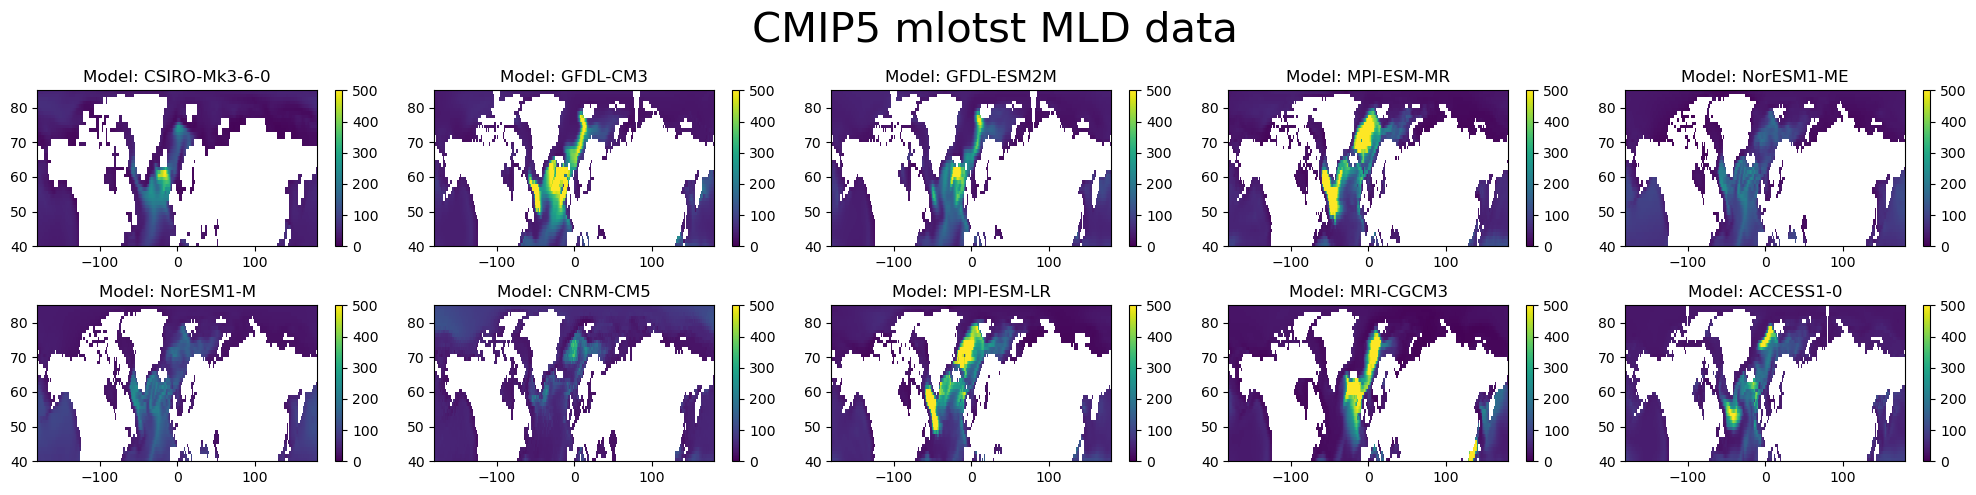

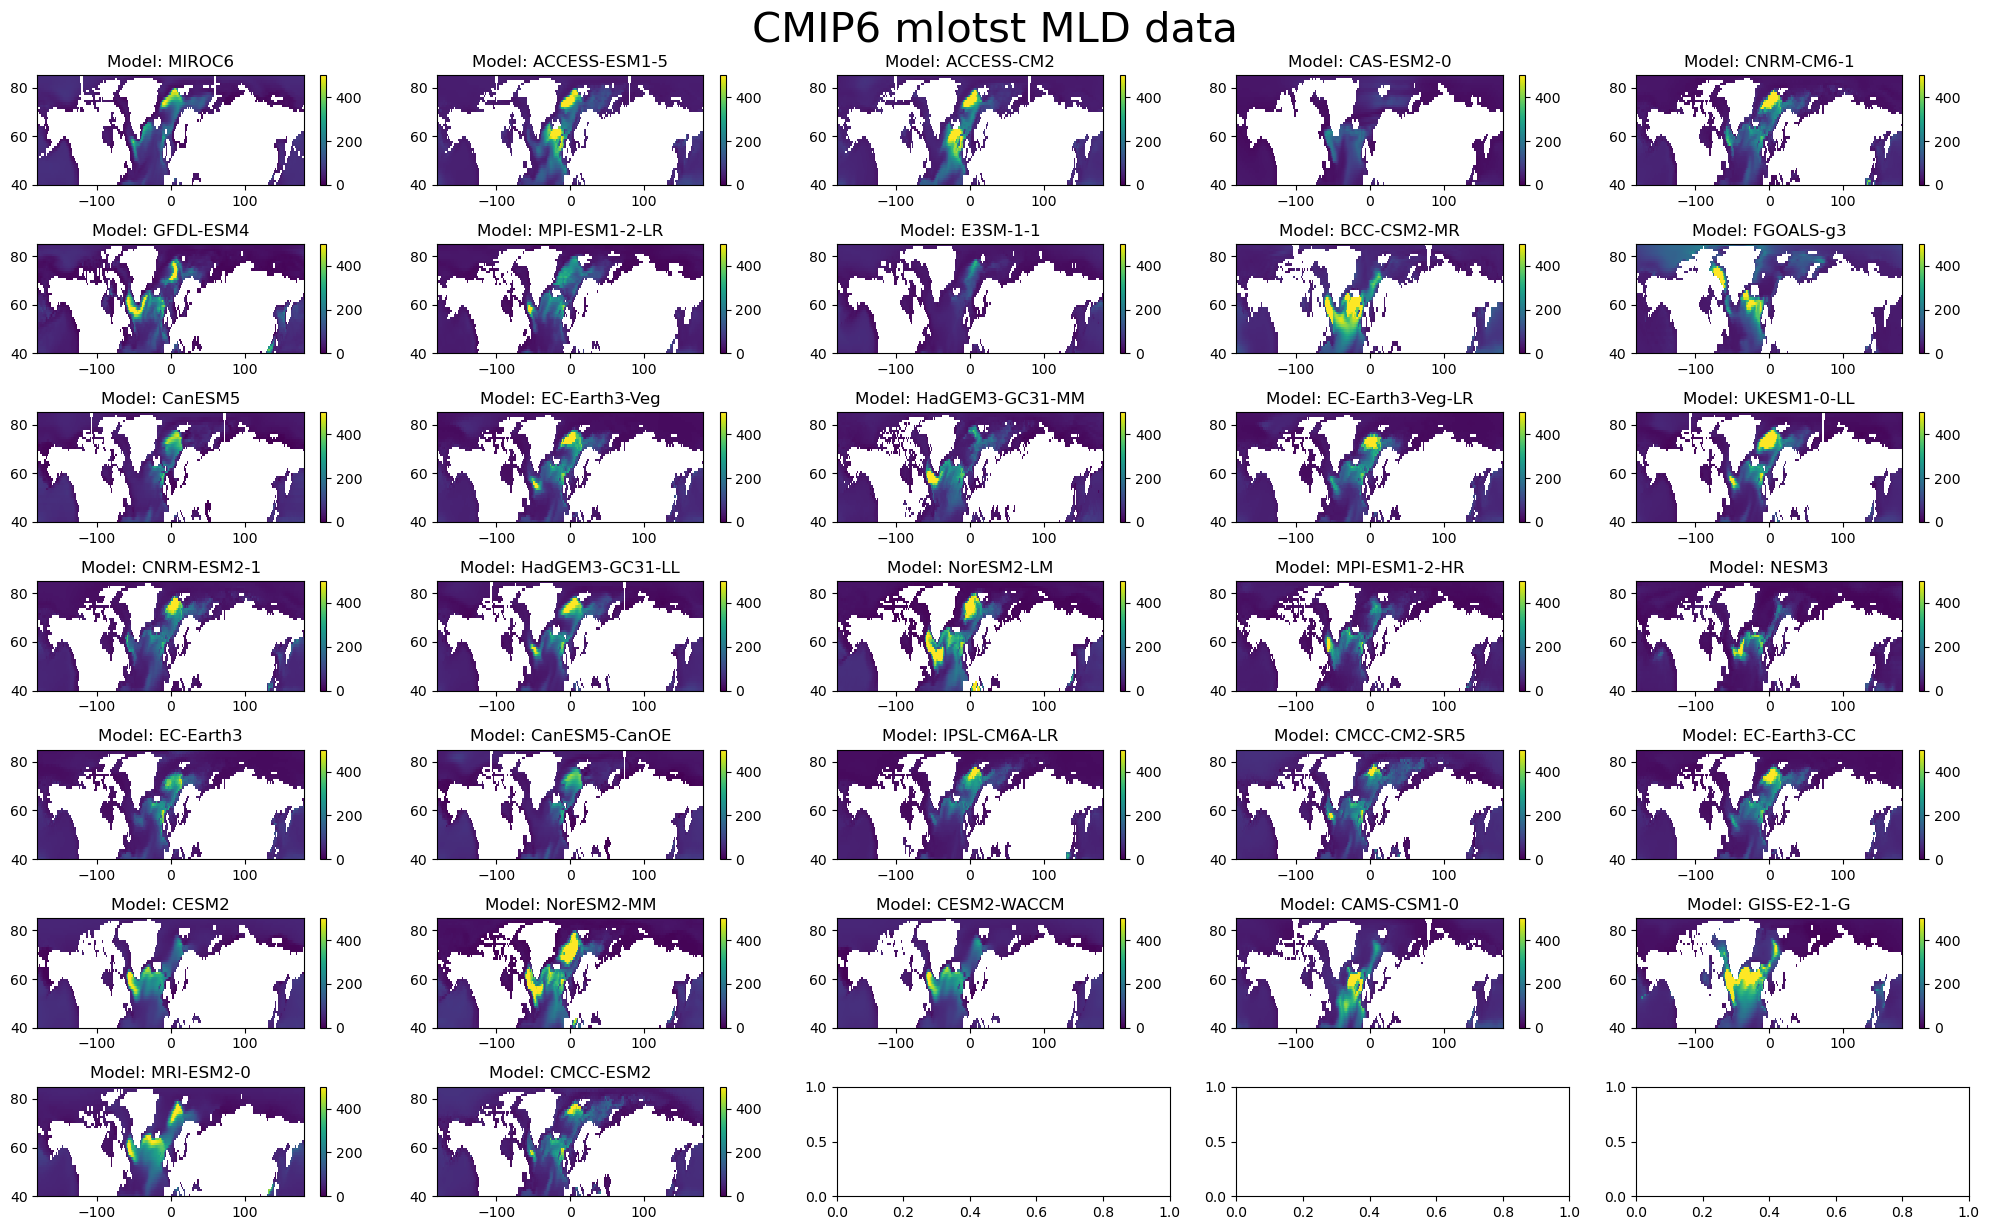

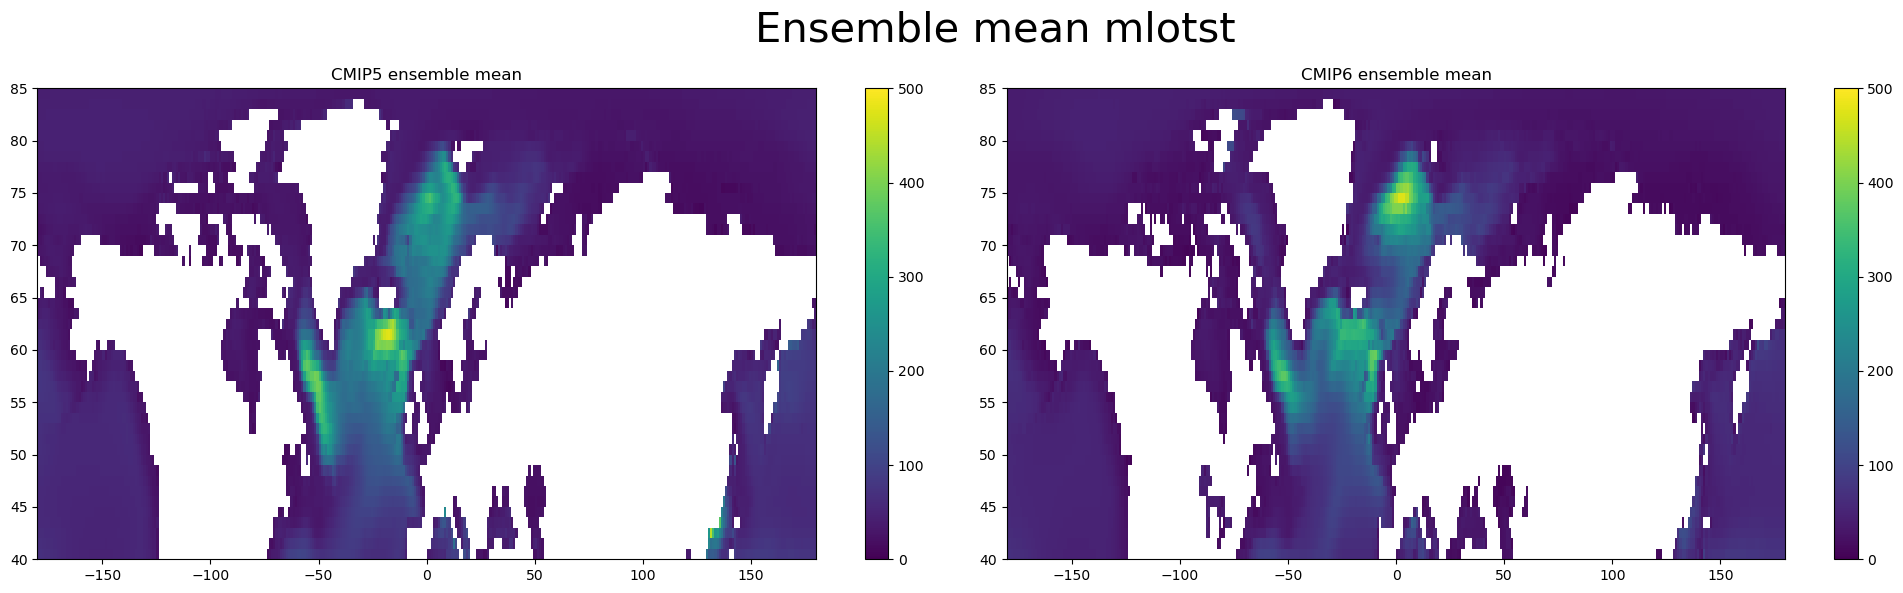

In [28]:
fig,axs = plt.subplots(2,5, figsize=(20,5))
ax = axs.flatten()

for i, mod in enumerate(MLD_mlotst_CMIP5.model.values):
    im = ax[i].pcolormesh(MLD_mlotst_CMIP5.lon, MLD_mlotst_CMIP5.lat,MLD_mlotst_CMIP5.isel(model=i).MLD, vmin=0, vmax=500)
    ax[i].set_title(f'Model: {MLD_mlotst_CMIP5.model.values[i]}')
    plt.colorbar(im, ax=ax[i])
fig.suptitle('CMIP5 mlotst MLD data',fontsize=(30))
fig.tight_layout()


fig,axs = plt.subplots(7,5, figsize=(20,12.5))
ax = axs.flatten()

for i, mod in enumerate(MLD_mlotst_CMIP6.model.values):
    im = ax[i].pcolormesh(MLD_mlotst_CMIP6.lon, MLD_mlotst_CMIP6.lat,MLD_mlotst_CMIP6.isel(model=i).MLD, vmin=0, vmax=500)
    ax[i].set_title(f'Model: {MLD_mlotst_CMIP6.model.values[i]}')
    plt.colorbar(im, ax=ax[i])

fig.suptitle('CMIP6 mlotst MLD data',fontsize=(30))
fig.tight_layout()

fig,axs = plt.subplots(1,2,figsize=(20,6))
ax = axs.flatten()

im = ax[0].pcolormesh(MLD_mlotst_CMIP5.lon, MLD_mlotst_CMIP5.lat,MLD_mlotst_CMIP5.mean(dim='model').MLD, vmin=0, vmax=500)
ax[0].set_title(f'CMIP5 ensemble mean')
plt.colorbar(im, ax=ax[0])

im = ax[1].pcolormesh(MLD_mlotst_CMIP6.lon, MLD_mlotst_CMIP6.lat,MLD_mlotst_CMIP6.mean(dim='model').MLD, vmin=0, vmax=500)
ax[1].set_title(f'CMIP6 ensemble mean')
plt.colorbar(im, ax=ax[1])

fig.suptitle('Ensemble mean mlotst',fontsize=(30))
fig.tight_layout()

### From C. Heuzé et al. (2021)

Since only few models have mlotst available for CMIP5, we also include MLD data from the study by C. Heuzé (2021) Antarctic Bottom Water and North Atlantic Deep Water in CMIP6 models, Ocean Science, doi:10.5194/os-17-59-2021, vol 17, pp 59-90.

In [29]:
# Read MLD data from Heuzé publication. Here, the from Heuze
"""
Read all files and assign lon2: lon from 180 to 180 degrees instead of 0 to 360
Append the different data sets in: MLD_CM5 and MLD_CM6
"""

all_files5 = glob.glob(original_data_dir+"cmip5_mld_heuze/*.nc")
all_files6 = glob.glob(original_data_dir+"cmip6_mld_heuze/*.nc")
all_files5 = np.sort(all_files5);
all_files6 = np.sort(all_files6);

MLD_CM5 = []
mods_CM5 = []
for i in range(len(all_files5)):
    MLD_data = xr.open_mfdataset(all_files5[i])
    mod_name = MLD_data.model.values
    if mod_name in zos_mods5:
        MLD_data = MLD_data.set_coords(("lat", "lon"))
        MLD_data = MLD_data.assign_coords(model=mod_name)
        MLD_CM5.append(MLD_data)
        mods_CM5.append(mod_name)
    else:
        print(f'This CMIP5 model does not have ODSL data available: {mod_name}')
mods_CM5 = np.transpose(mods_CM5)

MLD_CM6 = [] 
mods_CM6 = []
for i in range(len(all_files6)):
    MLD_data = xr.open_mfdataset(all_files6[i])
    mod_name = all_files6[i][34:-40]    
    if mod_name in zos_mods6:
        MLD_data = MLD_data.set_coords(("lat", "lon"))
        MLD_data = MLD_data.assign_coords(model=mod_name)
        MLD_data = MLD_data.isel(time=0)                      
        MLD_CM6.append(MLD_data)
        mods_CM6.append(mod_name)
    else:
        print(f'This CMIP6 model does not have ODSL data available: {mod_name}')
        
print(f'Number of models with MLD-Heuzé and zos in CMIP5: {len(mods_CM5)}')
print(f'Number of models with MLD-Heuzé and zos in CMIP6: {len(mods_CM6)}')


This CMIP5 model does not have ODSL data available: CESM1-CAM5
This CMIP5 model does not have ODSL data available: FGOALS-g2
This CMIP5 model does not have ODSL data available: GISS-E2-H
This CMIP6 model does not have ODSL data available: GISS-E2-1-H
This CMIP6 model does not have ODSL data available: MCM-UA-1-0
This CMIP6 model does not have ODSL data available: SAM0-UNICON
Number of models with MLD-Heuzé and zos in CMIP5: 22
Number of models with MLD-Heuzé and zos in CMIP6: 5


The models in this dataset do not use the same grid however. So we need to regrid to the same grid as for mlotst:

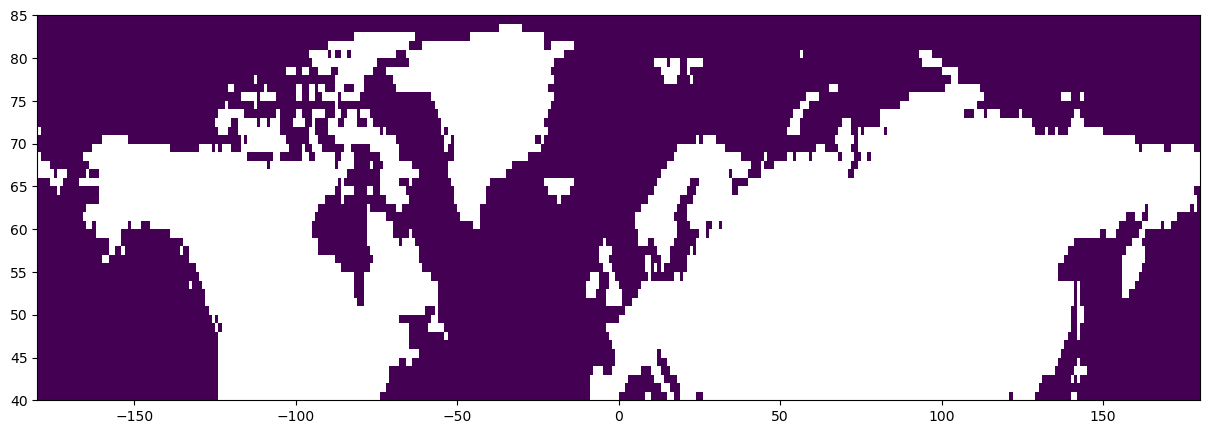

In [30]:
def rotate_longitude(ds, name_lon):

    ds = ds.assign_coords({name_lon:(((ds[name_lon] + 180 ) % 360) - 180)})
    ds = ds.sortby(ds[name_lon])

    return ds

fig, ax = plt.subplots(1,1,figsize=(15,5))

mask_ds = xr.open_dataset('Raw_Data/reference_masks.nc')
mask_ds = rotate_longitude(mask_ds, 'lon')
mask_ds = mask_ds.sel(lat=slice(40,85))

plt.pcolormesh(mask_ds.lon, mask_ds.lat, mask_ds.mask);

In [31]:
weights = np.cos(np.deg2rad(mask_ds.lat))
weights.name = 'weights'

# Make a dataset to regrid with xESMF
ds_out = xr.Dataset({'lat': (['lat'], mask_ds.lat.values),
                     'lon': (['lon'], mask_ds.lon.values)})

regridded_Heuze_CMIP5 = []
regridded_Heuze_CMIP6 = []

for i in range(len(MLD_CM5)):
    y_ds = MLD_CM5[i]

    try: 
        reg_method = 'nearest_s2d'
        regridder = xe.Regridder(y_ds, ds_out, reg_method, periodic=True)
        #print(regridder)
    except:
        print('fail')

    dr_out = regridder(y_ds, keep_attrs=True)
    regridded_Heuze_CMIP5.append(dr_out)   

for i in range(len(MLD_CM6)):
    y_ds = MLD_CM6[i]

    try: 
        reg_method = 'nearest_s2d'
        regridder = xe.Regridder(y_ds, ds_out, reg_method, periodic=True)
        #print(regridder)
    except:
        print('fail')

    dr_out = regridder(y_ds, keep_attrs=True)
    regridded_Heuze_CMIP6.append(dr_out)    

MLD_Heuze_regridded_CMIP5 = xr.concat(regridded_Heuze_CMIP5, dim='model')
MLD_Heuze_regridded_CMIP6 = xr.concat(regridded_Heuze_CMIP6, dim='model')

MLD_Heuze_regridded_CMIP5['MLD'] = xr.where(mask_ds.sel(lat=slice(40,85)).mask == 1, MLD_Heuze_regridded_CMIP5.MLD,  np.nan)
MLD_Heuze_regridded_CMIP6['MLD'] = xr.where(mask_ds.sel(lat=slice(40,85)).mask == 1, MLD_Heuze_regridded_CMIP6.MLD,  np.nan)

In [32]:
# Save to netcdf
MLD_Heuze_regridded_CMIP5.to_netcdf('Data/CMIP5_spatial_MLD_Heuze.nc')
MLD_Heuze_regridded_CMIP5.to_netcdf('Data/CMIP6_spatial_MLD_Heuze.nc')

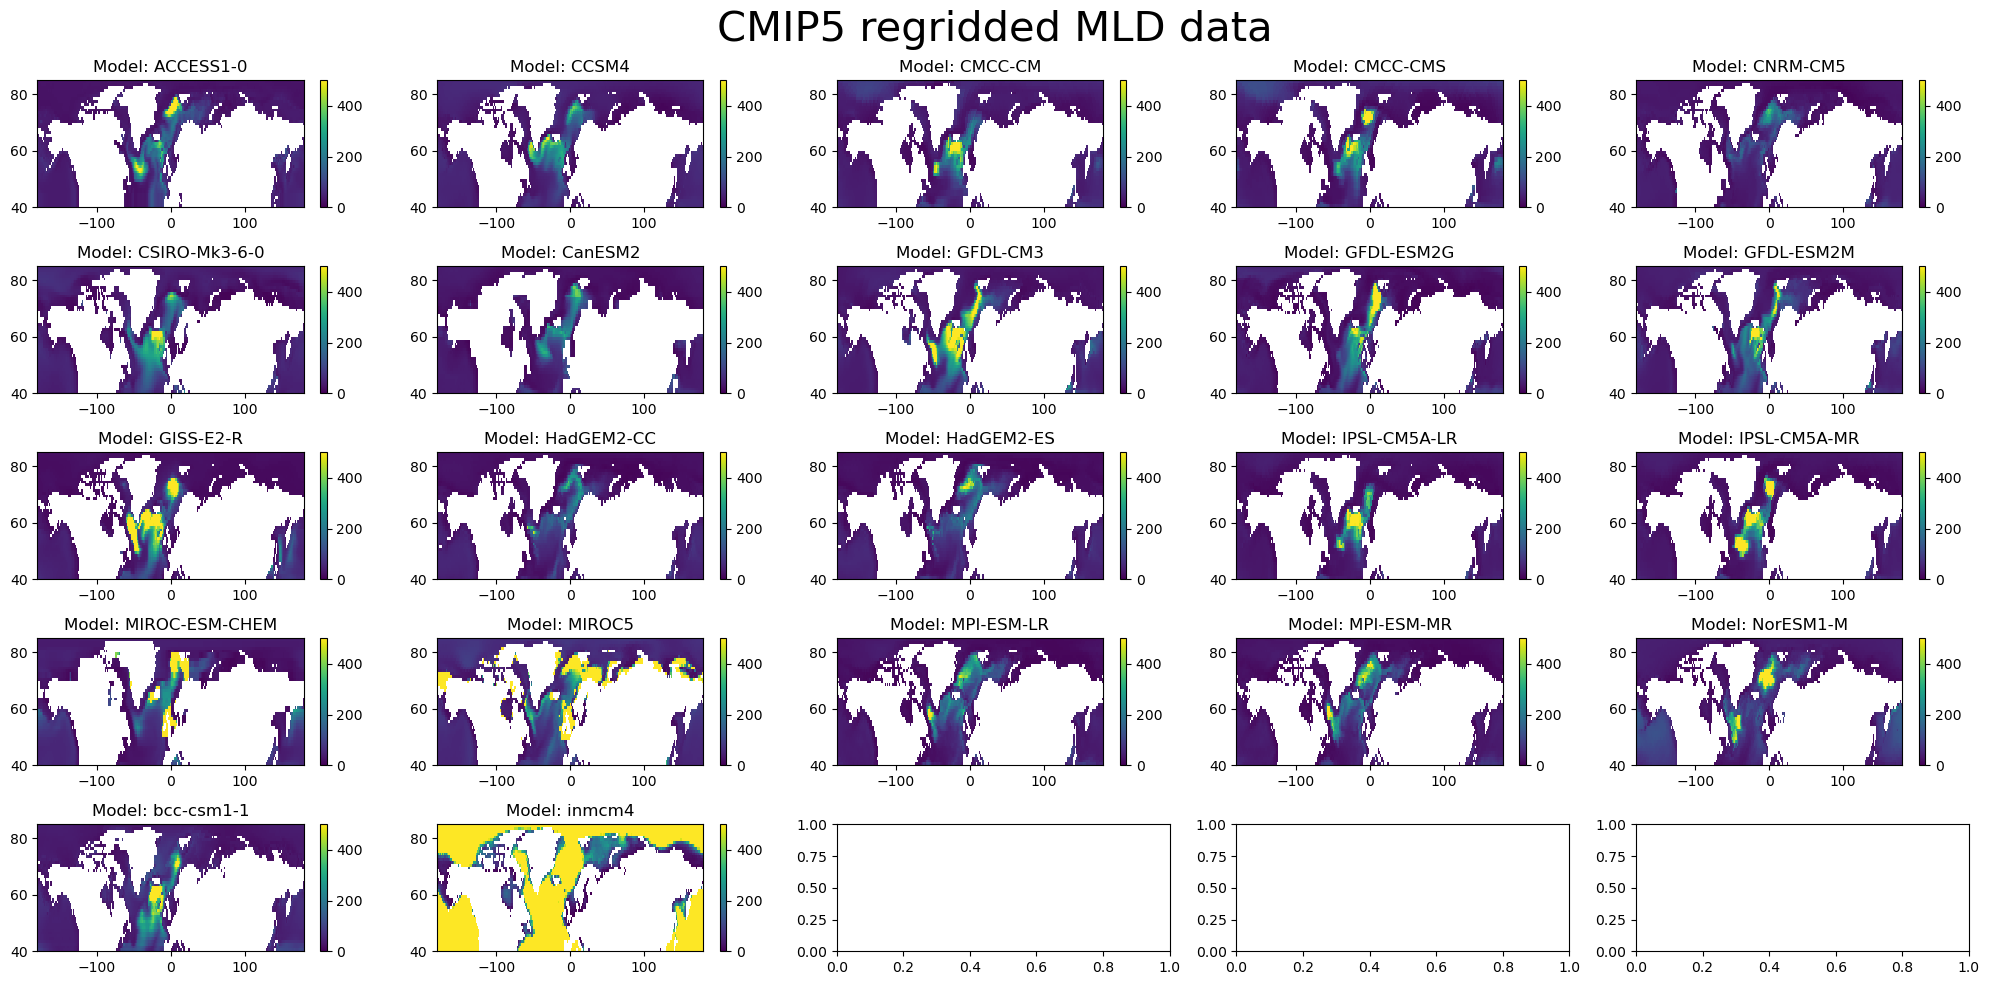

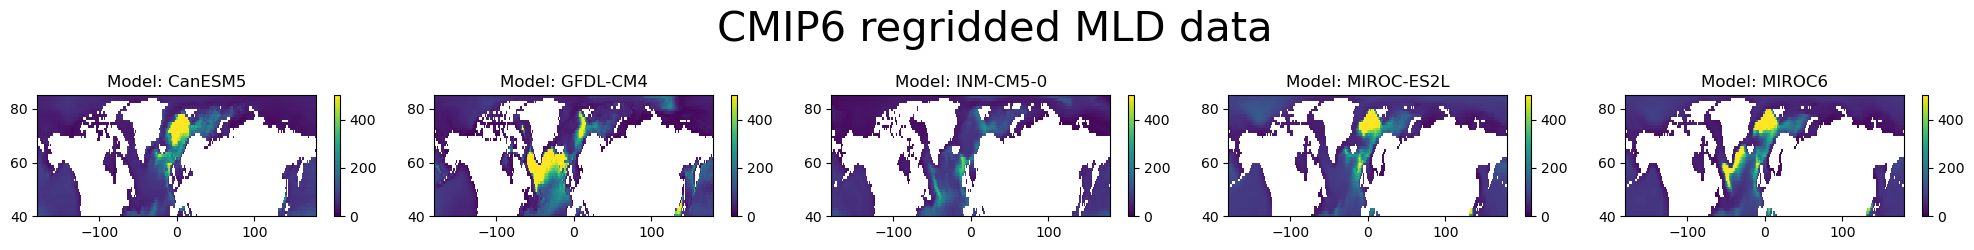

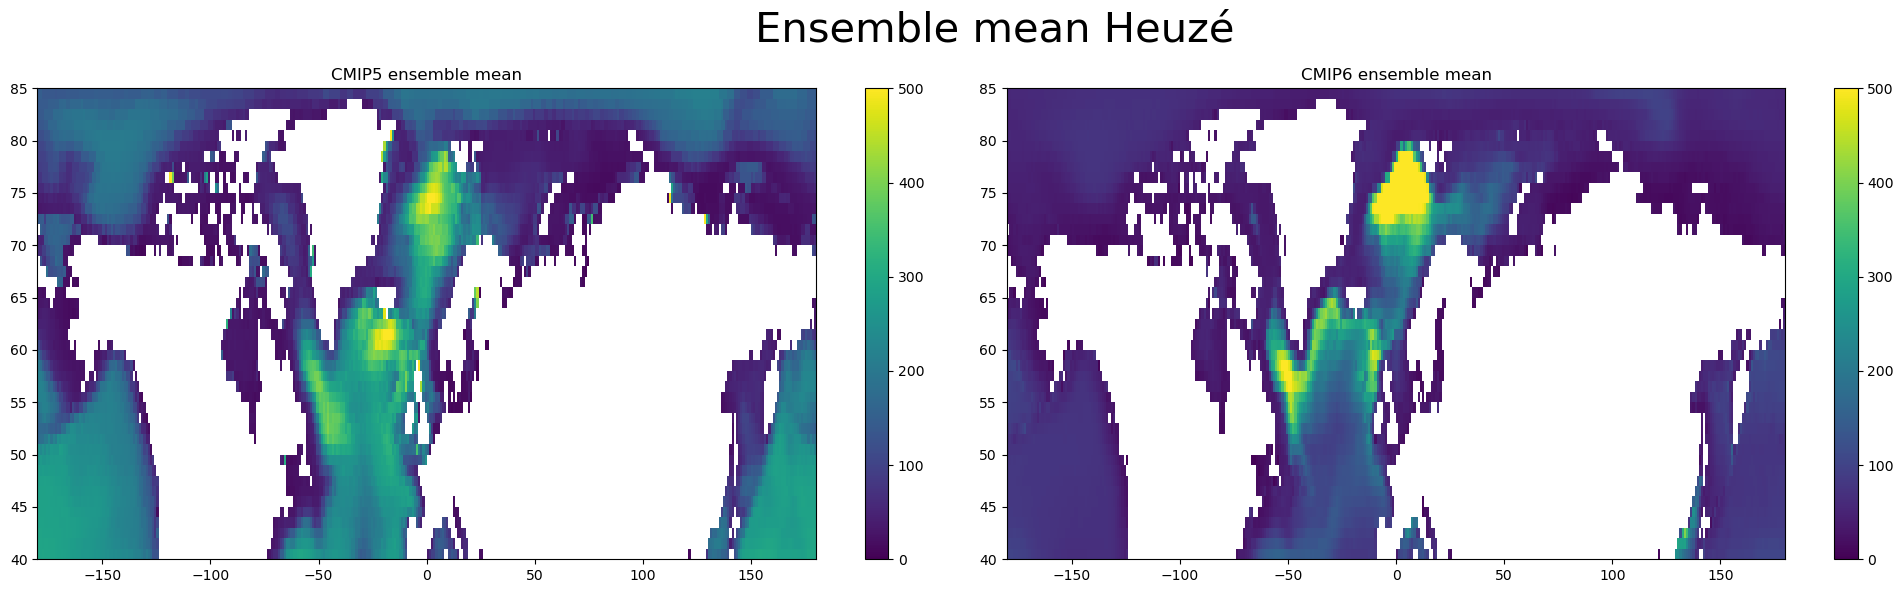

In [33]:
fig,axs = plt.subplots(5,5, figsize=(20,10))
ax = axs.flatten()

for i, mod in enumerate(MLD_Heuze_regridded_CMIP5.model.values):
    im = ax[i].pcolormesh(MLD_Heuze_regridded_CMIP5.lon, MLD_Heuze_regridded_CMIP5.lat,MLD_Heuze_regridded_CMIP5.isel(model=i).MLD, vmin=0, vmax=500)
    ax[i].set_title(f'Model: {MLD_Heuze_regridded_CMIP5.model.values[i]}')
    plt.colorbar(im, ax=ax[i])
fig.suptitle('CMIP5 regridded MLD data',fontsize=(30))
fig.tight_layout()


fig,axs = plt.subplots(1,5, figsize=(20,2.5))
ax = axs.flatten()

for i, mod in enumerate(MLD_Heuze_regridded_CMIP6.model.values):
    im = ax[i].pcolormesh(MLD_Heuze_regridded_CMIP6.lon, MLD_Heuze_regridded_CMIP6.lat,MLD_Heuze_regridded_CMIP6.isel(model=i).MLD, vmin=0, vmax=500)
    ax[i].set_title(f'Model: {MLD_Heuze_regridded_CMIP6.model.values[i]}')
    plt.colorbar(im, ax=ax[i])

fig.suptitle('CMIP6 regridded MLD data',fontsize=(30))
fig.tight_layout()

fig,axs = plt.subplots(1,2,figsize=(20,6))
ax = axs.flatten()

im = ax[0].pcolormesh(MLD_Heuze_regridded_CMIP5.lon, MLD_Heuze_regridded_CMIP5.lat,MLD_Heuze_regridded_CMIP5.mean(dim='model').MLD, vmin=0, vmax=500)
ax[0].set_title(f'CMIP5 ensemble mean')
plt.colorbar(im, ax=ax[0])

im = ax[1].pcolormesh(MLD_Heuze_regridded_CMIP6.lon, MLD_Heuze_regridded_CMIP6.lat,MLD_Heuze_regridded_CMIP6.mean(dim='model').MLD, vmin=0, vmax=500)
ax[1].set_title(f'CMIP6 ensemble mean')
plt.colorbar(im, ax=ax[1])

fig.suptitle('Ensemble mean Heuzé',fontsize=(30))
fig.tight_layout()


### Concatenate these two sources for MLD (mlotst and Heuze)

In [34]:
# Check double model names
# Use mlotst if available, otherwise Heuze

double_MLD_models_CMIP5 = list(set(MLD_mlotst_CMIP5.model.values)&set(MLD_Heuze_regridded_CMIP5.model.values))
double_MLD_models_CMIP6 = list(set(MLD_mlotst_CMIP6.model.values)&set(MLD_Heuze_regridded_CMIP6.model.values))

MLD_Heuze_concat_CMIP5 = MLD_Heuze_regridded_CMIP5.drop_sel(model=double_MLD_models_CMIP5)
MLD_Heuze_concat_CMIP6 = MLD_Heuze_regridded_CMIP6.drop_sel(model=double_MLD_models_CMIP6)


In [35]:
MLD_CMIP5 = xr.concat([MLD_mlotst_CMIP5, MLD_Heuze_concat_CMIP5],dim='model')
MLD_CMIP6 = xr.concat([MLD_mlotst_CMIP6, MLD_Heuze_concat_CMIP6],dim='model')

In [36]:
MLD_CMIP5.to_netcdf('Data/CMIP5_spatial_MLD.nc')
MLD_CMIP6.to_netcdf('Data/CMIP6_spatial_MLD.nc')

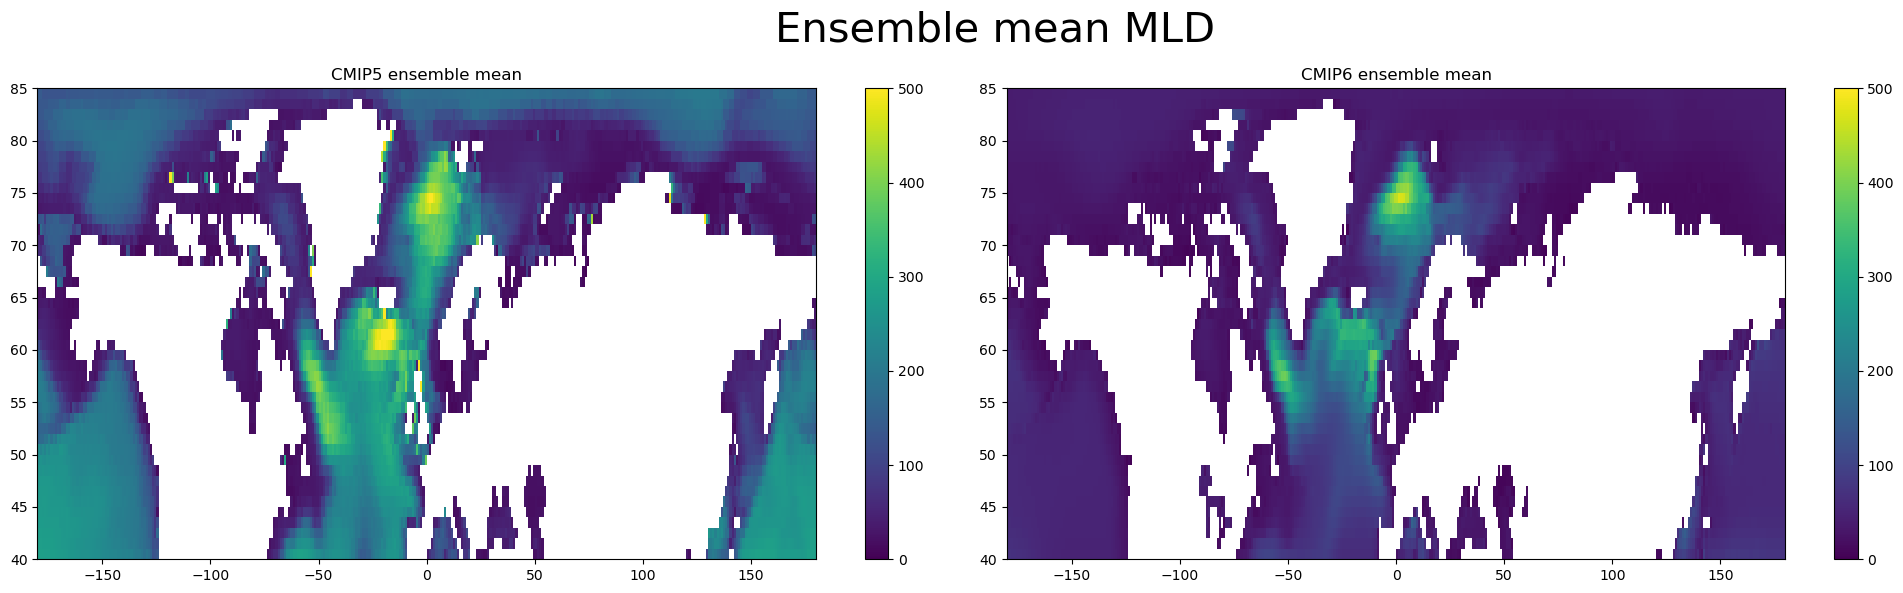

In [37]:
fig,axs = plt.subplots(1,2,figsize=(20,6))
ax = axs.flatten()

im = ax[0].pcolormesh(MLD_CMIP5.lon, MLD_CMIP5.lat,MLD_CMIP5.mean(dim='model').MLD, vmin=0, vmax=500)
ax[0].set_title(f'CMIP5 ensemble mean')
plt.colorbar(im, ax=ax[0])

im = ax[1].pcolormesh(MLD_CMIP6.lon, MLD_CMIP6.lat,MLD_CMIP6.mean(dim='model').MLD, vmin=0, vmax=500)
ax[1].set_title(f'CMIP6 ensemble mean')
plt.colorbar(im, ax=ax[1])

fig.suptitle('Ensemble mean MLD',fontsize=(30))
fig.tight_layout()
